<a href="https://colab.research.google.com/github/ardadastan04/projects/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5

We have learned about the basics of using machine learning and deep learning for many computer vision problems, including object classification, semantic segmentation, object detection, etc. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

# 0. Setup

In [ ]:
import os

if not os.path.exists("CS131_release"):
    # Clone the repository if it doesn't already exist
    !git clone https://github.com/StanfordVL/CS131_release.git

%cd CS131_release/winter_2025/hw5_release/

/content/CS131_release/winter_2025/hw5_release


In [ ]:
# Install the necessary dependencies
# (restart your runtime session if prompted to, and then re-run this cell)
!pip install -r requirements.txt

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`.

As a quick refresher question. Why do we want to split our data into training and testing sets?

**You answer here:**
We want to split data into training and testing sets because training on all of the data may just cause the model to learn patterns specific to that data but testing on a separate batch lets us see how it deals with data it has not seen before.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

# set random seeds
torch.manual_seed(131)
np.random.seed(131)
random.seed(131)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10, so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

Why do we want to normalize the images beforehand?

*HINT*: consider the fact that the network we developed will be deployed to a large number of images.

**You answer here:** We want to normalize the images beforehand to make sure we have consistency in what we are feeding into the model, faster convergence times, and consistency in terms of features and improved performance.



In [ ]:
trainloader = None
testloader = None
batch_size = 4

### YOUR CODE HERE
transform = transforms.Compose([transforms.ToTensor(),
                                torchvision.transforms.Normalize((.5,.5,.5),(.5,.5,.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
### END YOUR CODE

# these are the 10 classes we have in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# running this block will take a few minutes to download the dataset if you haven't done so

Files already downloaded and verified
Files already downloaded and verified


Let's plot out some training images to see what we are dealing with:

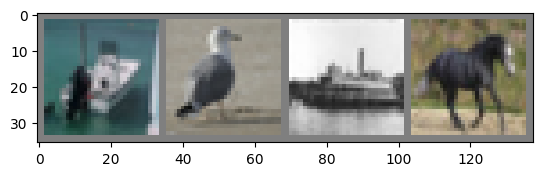

 ship  bird  ship horse


In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `Net`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ### YOUR CODE HERE
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)


        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        ### END YOUR CODE

    def forward(self, x):
        ### YOUR CODE HERE
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END YOUR CODE
        return x

net = Net()

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start).

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take just several minutes on your CPU.

In [ ]:
epoch_num = 2
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.272
[1,  4000] loss: 1.905
[1,  6000] loss: 1.674
[1,  8000] loss: 1.588
[1, 10000] loss: 1.524
[1, 12000] loss: 1.468
[2,  2000] loss: 1.391
[2,  4000] loss: 1.360
[2,  6000] loss: 1.360
[2,  8000] loss: 1.328
[2, 10000] loss: 1.309
[2, 12000] loss: 1.262
Finished Training


The last step of training is to save the trained model locally to a checkpoint:

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

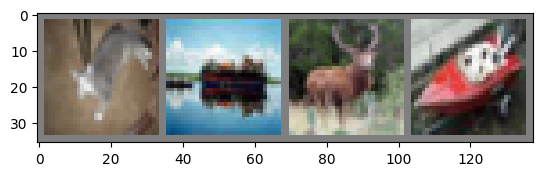

GroundTruth:    cat  ship  deer  ship


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let's load in our saved model checkpoint and get its output:

In [ ]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))

<ipython-input-11-29cc67ce303c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []
### YOUR CODE HERE
out = net(images)
_, predicted = torch.max(out, 1)
### END YOUR CODE
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  deer truck


How does your prediction look like? Does that match your expectation? Write a few sentences to describe what you got and provide some analysis if you have any.

**You answer here:** My prediction generally has 2-3 out of the 4 correct. This mathces my expectation because I am not consistently getting 3/4 right, and I did not expect it to classify all of them perfectly but at least half. I think this is a reasonable accuracy considering the current architecture of the model.  



Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

with torch.no_grad():
    for data in testloader:

        images, labels = data

        # Similar to the previous question, calculate model's output and the percentage as correct / total
        ### YOUR CODE HERE
        out = net(images)
        _, pred = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        ### END YOUR CODE

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better?

**You answer here:** The accuracy is around ~55 percent. Compared to random guessing, it does perform significantly better, since the chances of selecting the correct class out of 10 are 10%, which is significantly lower than 55%.



Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # repeat what you did previously, but now for each class
        ### YOUR CODE HERE
        out = net(images)
        _, pred = torch.max(out.data, 1)

        for label, prediction in zip(labels, pred):
          if label == prediction:
            correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

        ### END YOUR CODE

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 69.1 %
Accuracy for class car   is: 78.8 %
Accuracy for class bird  is: 16.5 %
Accuracy for class cat   is: 41.5 %
Accuracy for class deer  is: 49.8 %
Accuracy for class dog   is: 52.4 %
Accuracy for class frog  is: 64.4 %
Accuracy for class horse is: 58.6 %
Accuracy for class ship  is: 63.8 %
Accuracy for class truck is: 47.2 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance as much as possible. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not?

**You answer here:** Changing batch size (increasing or decreasing) did not work for me, as both lowered my model performance. Changing the optimizer to Adam also made my performance worse, since SGD is apparently better suited to image classifciation than Adam. Finally, I increased the number of epochs, which improved my performance from ~55 percent to ~63 percent, since the model was going through the training dataset multiple times (10 instead of the default 2).



In [ ]:
epoch_num = 10
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

## 2. Extra Credit: further improve your model performance

You have just tried tuning the hyper-parameters to improve your model performance. It's a very important part but not all! In this section, you are encouraged to read online to explore other options to further enhance your model. You may or may not need additional compute resources depending on what you do. But if you do need GPUs, Google Colab could be a great point to start.

Since this a free-form section, you should report here in detail what you have done, and feel free to submit any additional files if needed (e.g., additional code files). We'll be grading based on the effort you spend and the performance you achieved.

**You answer here:** Write your answer in this markdown cell.

